In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn import svm
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal


# you can choose one of the following package for image reading/processing
import cv2
import PIL


# 1 Support Vector Machine (SVM)

In [ ]:
x_data = pd.read_csv("/content/drive/MyDrive/ML/hw3/x_train.csv",header = None)/255
t_train = pd.read_csv("/content/drive/MyDrive/ML/hw3/t_train.csv",header = None)
x_data = np.array(x_data)
t_train = np.array(t_train).flatten()

print(x_data.shape)
print(t_train.shape)

(300, 784)
(300,)


## PCA

In [ ]:
def PCA(X):
  mean = np.mean(X, axis=0)
  std = np.std(X, axis=0, ddof=0)
  X = X - mean
  cov = np.cov(X.T)
  eigenvalues, eigenvectors = np.linalg.eig(cov)
  eigenvectors = eigenvectors.T
  idxs = np.argsort(eigenvalues)[::-1]
  eigenvalues = eigenvalues[idxs] 
  eigenvectors = eigenvectors[idxs]
  components = eigenvectors[0:2]
  return np.real(np.dot(X, components.T))

x_train = PCA(x_data)
print(x_train.shape)

(300, 2)


## SVM

In [ ]:
class SVM:
  def __init__(self,x_train,t_train ,C=1, kernel_type='linear'):
    self.x = x_train
    self.y = t_train
    self.C = C
    self.class_order = [(0, 1), (0, 2), (1, 2)]
    self.kernel_type = kernel_type
    self.X, self.target = self.make_X_t(self.x,self.y) 
    self.weights, self.bias, self.support_vector = self.cal_w_b(self.X, self.target)
    self.xx, self.yy = self.make_meshgrid(x_train[:,0], x_train[:,1])

  def make_X_t(self,x,y):
    X={}
    target={}
    for i in self.class_order:
      target[i] = np.concatenate((np.ones(100),np.full([100], -1)))
      class1_index = np.where(y == i[0])
      class2_index = np.where(y == i[1])
      X[i] = np.vstack((x[class1_index],x[class2_index]))
    return X,target

    
  def cal_phix(self,X):
    if self.kernel_type == 'linear':
      return X
    else:
      temp = []
      for x in X:
        temp.append([x[0]**2, np.sqrt(2)*x[0]*x[1], x[1]**2])
      temp = np.array(temp)
      return temp
  
  def kernel_function(self, xi, xj):
    return np.dot(xi, xj.T)
  
  def target_for_oao(self,t_train):
    # class1={1}, class2={-1}, other class={0}
    target= {}
    for i in self.class_order:
      target[i] = np.zeros(self.x.shape[0])
      class1_index = np.where(t_train==i[0])
      class2_index = np.where(t_train==i[1])
      target[i][class1_index] = 1
      target[i][class2_index] = -1
    print(target)
    return target

  def cal_w_b(self,X,target):
    weights = {}
    bias = {}
    support_vector = {}
    for i in self.class_order:
      if self.kernel_type == 'linear':
        clf = svm.SVC(kernel='linear', decision_function_shape='ovo')
      else:
        clf = svm.SVC(kernel='poly', C=1.8 , degree=2, decision_function_shape='ovo')
      clf.fit(X[i],target[i])
      dual_coef = clf.dual_coef_ # Lagrange multipliers中support vector的係數
      lagrange_coef = np.abs(clf.dual_coef_)
      support_index = clf.support_ #在train dataset各類的support vector的index
      support_vector[i] = clf.support_vectors_
      phix = self.cal_phix(support_vector[i])
      #print(phix)
      t = target[i]
      y = []
      y.append(t[support_index])
      y = np.array(y)
      #公式(7.29)計算weights
      weights[i] = np.dot(dual_coef, phix)
      #公式(7.37)計算bias
      index_n = np.where((lagrange_coef[0] > 0) & (lagrange_coef[0] < self.C))
      index_m = np.nonzero(lagrange_coef)
      bias[i] = np.mean(y[0][index_n] - np.dot(phix[index_n], weights[i].T))
    return weights, bias, support_vector
  
  def make_meshgrid(self, x, y): 
    space = 0.01
    h=0.02
    x_min, x_max = x.min() - space, x.max() + space
    y_min, y_max = y.min() - space, y.max() + space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    return xx, yy

  def predict(self,):
    X = np.c_[self.xx.flatten(), self.yy.flatten()]
    if self.kernel_type =='poly':
      X_poly=[]
      for x in X:
        X_poly.append([x[0]**2, np.sqrt(2)*x[0]*x[1], x[1]**2])
      X = np.array(X_poly)
    else:
      X=X

    y = {}
    for i in self.class_order:
      weights = self.weights[i]
      bias = self.bias[i]
      #x = self.cal_phix(self.X[i])
      y[i] =  np.sign(np.dot(weights, X.T) + bias)
    predict = []
    for i in range(X.shape[0]):
      predict_class = {0: 0, 1: 0, 2: 0}
      for c1,c2 in self.class_order:
        if y[(c1,c2)][0][i] == 1:
          predict_class[c1]+=1
        else:
          predict_class[c2]+=1
      predict.append(max(predict_class, key=predict_class.get))
    predict = np.array(predict)
    predict = predict.reshape(self.xx.shape)
    return predict

  def plot(self,predict):
    plt.title(self.kernel_type)
    plt.scatter(self.support_vector[(0,1)][:,0], self.support_vector[(0,1)][:,1], facecolors='none', edgecolors='k', linewidths=2, label="support vector")
    plt.scatter(self.support_vector[(0,2)][:,0], self.support_vector[(0,2)][:,1], facecolors='none', edgecolors='k', linewidths=2)
    plt.scatter(self.support_vector[(1,2)][:,0], self.support_vector[(1,2)][:,1], facecolors='none', edgecolors='k', linewidths=2)
    class1_index = np.where(self.y == 0)
    class2_index = np.where(self.y == 1)
    class3_index = np.where(self.y == 2)
    plt.scatter(x_train[class1_index][:, 0], x_train[class1_index][:, 1], c='b', marker='x', label="chinese 1")
    plt.scatter(x_train[class2_index][:, 0], x_train[class2_index][:, 1], c='r', marker='*', label="chinese 2")
    plt.scatter(x_train[class3_index][:, 0], x_train[class3_index][:, 1], c='g', marker='o', label="chinese 4")
    plt.contourf(self.xx, self.yy, predict, cmap=plt.cm.brg, alpha=0.3)
    plt.legend()
    plt.show()



### Linear SVM

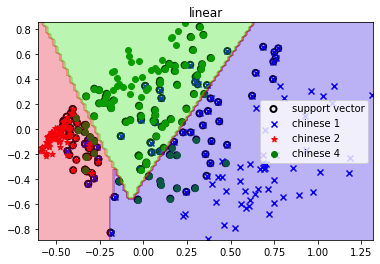

In [ ]:
linear_model = SVM(x_train, t_train) 
predict = linear_model.predict()
linear_model.plot(predict)

### Poly SVM

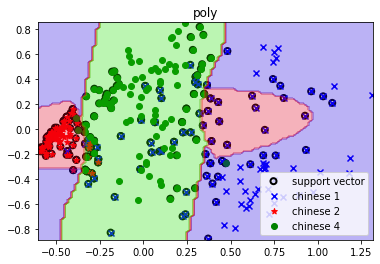

In [ ]:
poly_model = SVM(x_train, t_train, kernel_type='poly') 
predict = poly_model.predict()
poly_model.plot(predict)

# 2 Gaussian Mixture Model

In [ ]:
img = PIL.Image.open('/content/drive/MyDrive/ML/hw3/hw3.jpg')
img = np.asarray(img)/255
X = img.reshape(-1,3)
print(X.shape)

(252150, 3)


## K-means model

In [ ]:
image = PIL.Image.open('/content/drive/MyDrive/ML/hw3/hw3.jpg')
img = np.asarray(image)/255
X = img.reshape(img.shape[0]*img.shape[1],3)
print(X.shape)

(252150, 3)


In [ ]:
class Kmeans:
  def __init__(self, X, k):
    self.X = X
    self.k = k
    self.clusters = np.zeros((X.shape[0],1))
    self.centroids = X[np.random.choice(len(X), k)] # 隨機地取K個向量當成每群的中心點

  def make_cluster(self,centroids):
    clusters = np.zeros((self.X.shape[0],1))
    temp = np.empty((self.X.shape[0],1))
    for i in range(self.k):
      mu_k = np.ones((self.X.shape[0],1))*centroids[i]
      each_distance = np.sum((self.X-mu_k)**2,axis=1)
      each_distance = np.array(each_distance)
      each_distance.resize((self.X.shape[0],1))
      temp = np.append(temp,each_distance,axis=1)
    temp = np.delete(temp,0,axis=1)
    clusters = np.argmin(temp, axis=1) # 每個向量被分類到距離最短的中心
    return clusters
  
  def update_centroids(self,clusters):
    new_centroids = np.empty((self.k, self.X.shape[1]))
    for i in range(self.k):
      #對每一群算出新的向量平均值，以此做為新的群中心
      new_centroids[i] = np.mean(self.X[np.where(clusters==i)],axis=0)
    new_centroids = np.array(new_centroids)
    return new_centroids

  def predict(self):
    centroids = self.centroids
    while True:
      # 更新 cluster
      self.clusters = self.make_cluster(self.centroids)
      # 更新 centroid
      centroids = self.update_centroids(self.clusters)
      #將新的群中心與舊的群中心作比較，如果不再有變動，表示已收斂
      if(centroids == self.centroids).all():
        break
      #else:
      self.centroids = centroids
    return centroids, self.clusters

  def show_img(self,centroids, cluster_labels):
    print("Kmeans ",self.k)
    for i in range(self.k):
      print(str(i+1), centroids[i])
    idx = self.make_cluster(centroids)
    image = np.reshape(centroids[idx,:],(img.shape[0],img.shape[1],3))
    plt.figure()
    plt.imshow(image)
    plt.show()

Kmeans  3
1 [0.14099275 0.12472841 0.07335362]
2 [0.69601509 0.73282964 0.74482236]
3 [0.41599789 0.46407809 0.30427942]


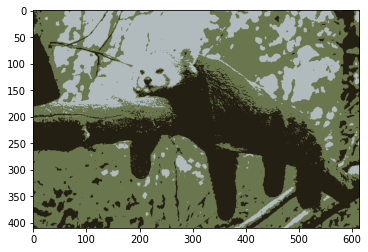

Kmeans  7
1 [0.80767936 0.84269822 0.88113682]
2 [0.25321217 0.25671245 0.14099588]
3 [0.61917214 0.65911774 0.65721075]
4 [0.49881413 0.54227186 0.4167335 ]
5 [0.35716486 0.44292442 0.24709394]
6 [0.56298217 0.3349111  0.22786242]
7 [0.08283556 0.06233658 0.04213978]


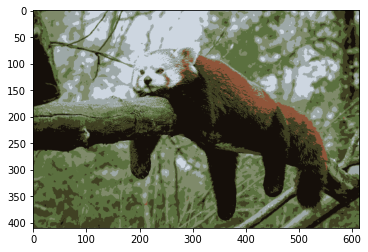

Kmeans  10
1 [0.06725564 0.05016972 0.03406048]
2 [0.64911665 0.41426243 0.28705538]
3 [0.33065435 0.29858441 0.22242891]
4 [0.83555887 0.86807705 0.90652797]
5 [0.28145861 0.41308014 0.13853641]
6 [0.49221643 0.54224779 0.41228764]
7 [0.3932998  0.47339297 0.28459005]
8 [0.57740713 0.6147563  0.58575093]
9 [0.20599842 0.17307674 0.10832995]
10 [0.68046446 0.72453879 0.75164546]


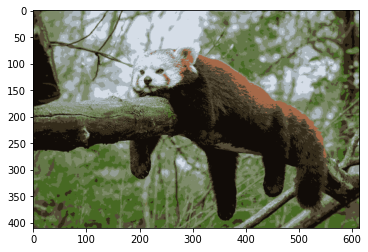

Kmeans  30
1 [0.39978557 0.54023689 0.2302218 ]
2 [0.79702059 0.83316525 0.87409945]
3 [0.03403066 0.02413002 0.01655251]
4 [0.66868413 0.43089283 0.30143178]
5 [0.28336337 0.36202184 0.17735512]
6 [0.27263576 0.26634978 0.21887368]
7 [0.62314833 0.68541231 0.71130959]
8 [0.22099162 0.10208833 0.0446643 ]
9 [0.5202681  0.56350995 0.52267195]
10 [0.78620174 0.72082109 0.67104072]
11 [0.32418153 0.45952875 0.18719027]
12 [0.19534257 0.28845015 0.07900756]
13 [0.550044   0.32279007 0.21792158]
14 [0.88407875 0.91318651 0.94913749]
15 [0.62644348 0.63715817 0.56447527]
16 [0.33775498 0.36192882 0.2804578 ]
17 [0.32945947 0.16493882 0.09711402]
18 [0.46472091 0.54587615 0.32705237]
19 [0.13366754 0.1251282  0.09145251]
20 [0.40738135 0.43256515 0.37045583]
21 [0.53949128 0.60773832 0.40044773]
22 [0.08795943 0.06593762 0.04359516]
23 [0.74880589 0.56384065 0.42679324]
24 [0.43374728 0.23693069 0.15865421]
25 [0.19923165 0.18680263 0.15635519]
26 [0.25906929 0.4151252  0.07863209]
27 [0.4716

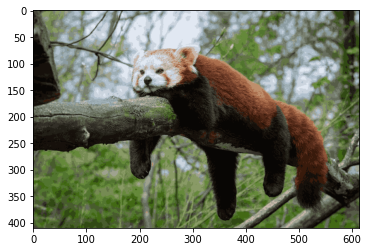

In [ ]:
K = [3, 7, 10, 30]
centroids_sets = []
cluster_labels_sets = []
for k in K:
  model = Kmeans(X, k=k)
  centroids, cluster_labels= model.predict()
  centroids_sets.append(centroids)
  cluster_labels_sets.append(cluster_labels)
  model.show_img(centroids, cluster_labels)

# Gaussian Mixture Model

In [ ]:
class GMM:
  def __init__(self,X , k=3, max_iter=100):
    self.X = X
    self.k = k
    self.max_iter = max_iter
    self.loglikelihood = []
    self.pi = None
    self.mu = None
    self.cov = None

  def cal_pi_mu_cov(self,centroids, predict_y):
    pi = [np.mean(predict_y == k) for k in range(self.k)] 
    pi = np.array(pi)
    self.pi = pi
    mu = centroids 
    mu = np.array(mu)
    self.mu = mu
    cov = [np.cov(X[np.where(predict_y==k)[0]].T) for k in range(self.k)]
    con = np.array(cov)
    self.cov = cov
    return pi,mu,cov  

  def E_step(self, pi, mu, cov):
    #multivariate_normal.pdf(self.X, mu[k], cov[k])
    likelihood = np.array([pi[k]*multivariate_normal.pdf(self.X, mean=mu[k], cov=cov[k], allow_singular=True) for k in range(self.k)]) 
    gamma = np.array(likelihood / np.sum(likelihood, axis=0)).T 
    return gamma, likelihood

  def M_step(self,gamma):
    N_k = np.sum(gamma, axis=0) 
    pi = N_k / self.X.shape[0] 
    mu = np.dot(gamma.T, self.X) /  N_k[:, np.newaxis] 
    cov = [(1/N_k[k]) * np.dot((gamma[:, k, np.newaxis]*(self.X - mu[k])).T, (self.X - mu[k])) for k in range(self.k)]
    return pi, mu, cov

  def EM_algorithm(self):
    for i in range(self.max_iter):
      # E step
      self.gamma, self.likelihood = self.E_step(self.pi, self.mu, self.cov)
      # M step
      self.pi, self.mu, self.cov = self.M_step(self.gamma)
      # log likelihood
      loglikelihood = np.sum(np.log(np.sum(self.likelihood, axis=0)))
      self.loglikelihood.append(loglikelihood)
    return self.likelihood, self.mu
    
  def show_GMM_img(self, likelihood, mu):
    idx = np.argmax(likelihood, axis=0)
    image = (mu[idx]*255).astype(int)
    image = PIL.Image.fromarray(image.reshape(img.shape[0], img.shape[1], 3).astype('uint8'))
    plt.title(f"GMM for k = {self.k}")
    plt.imshow(image)
    plt.show()
  def show_loglikelihood(self):
    plt.title('Log likelihood for k='+str(self.k))
    plt.xlabel('iteration')
    plt.ylabel('Log likelihood value')
    plt.plot(self.loglikelihood, label = 'log_likelihood')
    plt.legend()
    plt.show()

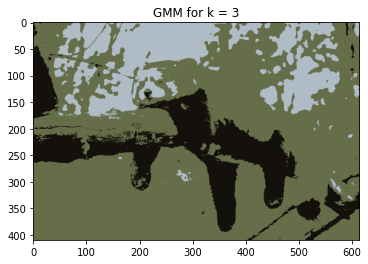

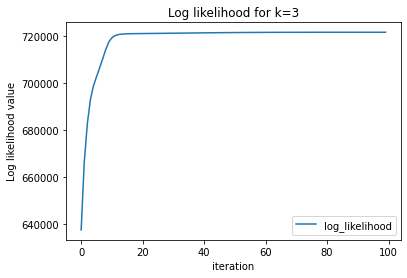

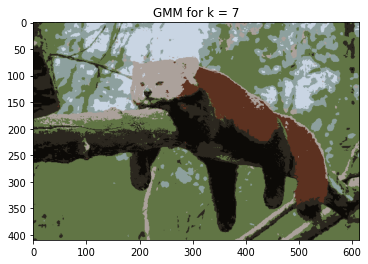

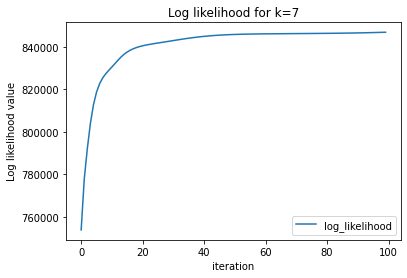

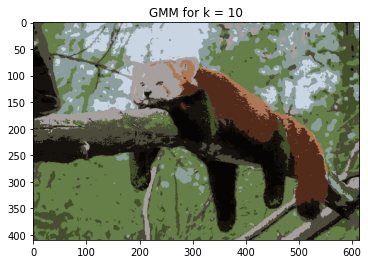

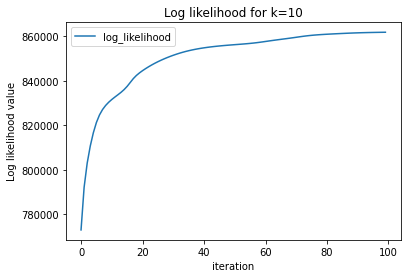

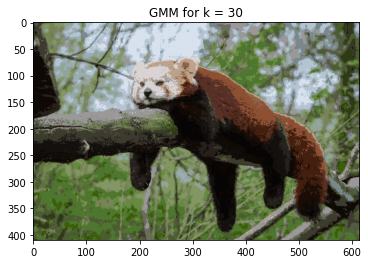

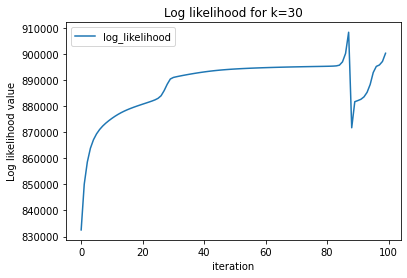

In [ ]:
K = [3, 7, 10, 30]
for idx, k in enumerate(K):
  #model_Kmeans = Kmeans(X, k=k)
  #centroids, y_pred = model_Kmeans.predict()
  centroids = centroids_sets[idx]
  y_pred = cluster_labels_sets[idx]
                
  model_GMM = GMM(X,k=k,max_iter=100)
  pi, mu, cov = model_GMM.cal_pi_mu_cov(centroids,y_pred)
  likelihood, mu = model_GMM.EM_algorithm()

  model_GMM.show_GMM_img(likelihood, mu)
  model_GMM.show_loglikelihood()
